In [1]:
import sys
assert sys.version_info >= (3, 7)

from packaging import version 
import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

import tensorflow as tf 
assert version.parse(tf.__version__) >= version.parse("2.8.0")

import matplotlib.pyplot as plt 

plt.rc("font", size = 14)
plt.rc("axes", labelsize = 14, titlesize = 14)
plt.rc("legend", fontsize = 14)
plt.rc("xtick", labelsize = 12)
plt.rc("ytick", labelsize = 12)

tf.config.list_physical_devices("GPU")

2025-08-27 17:27:02.147838: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-27 17:27:02.775079: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756297622.990745     938 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756297623.051837     938 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756297623.553598     938 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
sys.modules

{'sys': <module 'sys' (built-in)>,
 'builtins': <module 'builtins' (built-in)>,
 '_frozen_importlib': <module '_frozen_importlib' (frozen)>,
 '_imp': <module '_imp' (built-in)>,
 '_thread': <module '_thread' (built-in)>,
 '_warnings': <module '_warnings' (built-in)>,
 '_weakref': <module '_weakref' (built-in)>,
 '_io': <module '_io' (built-in)>,
 'marshal': <module 'marshal' (built-in)>,
 'posix': <module 'posix' (built-in)>,
 '_frozen_importlib_external': <module '_frozen_importlib_external' (frozen)>,
 'time': <module 'time' (built-in)>,
 'zipimport': <module 'zipimport' (frozen)>,
 '_codecs': <module '_codecs' (built-in)>,
 'codecs': <module 'codecs' (frozen)>,
 'encodings.aliases': <module 'encodings.aliases' from '/usr/lib/python3.12/encodings/aliases.py'>,
 'encodings': <module 'encodings' from '/usr/lib/python3.12/encodings/__init__.py'>,
 'encodings.utf_8': <module 'encodings.utf_8' from '/usr/lib/python3.12/encodings/utf_8.py'>,
 '_signal': <module '_signal' (built-in)>,
 '_ab

In [3]:
from sklearn.datasets import load_sample_images

images = load_sample_images()["images"]
images[0].shape


(427, 640, 3)

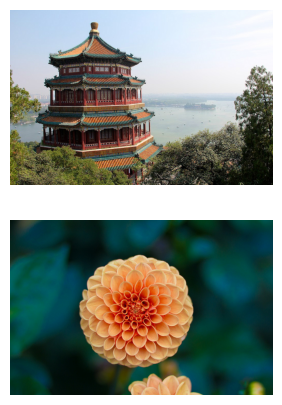

In [4]:
plt.figure(figsize=(5, 5))
plt.subplot(2,1, 1)
plt.imshow(images[0])
plt.axis("off")
plt.subplot(2,1, 2)
plt.imshow(images[1])
plt.axis("off")
plt.show()

In [5]:
images = tf.keras.layers.CenterCrop(height = 70, width = 120)(images)
images = tf.keras.layers.Rescaling(scale = 1/255)(images )
images.shape

I0000 00:00:1756297633.493502     938 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


TensorShape([2, 70, 120, 3])

In [6]:
tf.random.set_seed(42)
convLayer = tf.keras.layers.Conv2D(filters =32 , kernel_size=7)
featureMaps = convLayer(images)
featureMaps.shape

I0000 00:00:1756297635.400800     938 cuda_dnn.cc:529] Loaded cuDNN version 90300


TensorShape([2, 64, 114, 32])

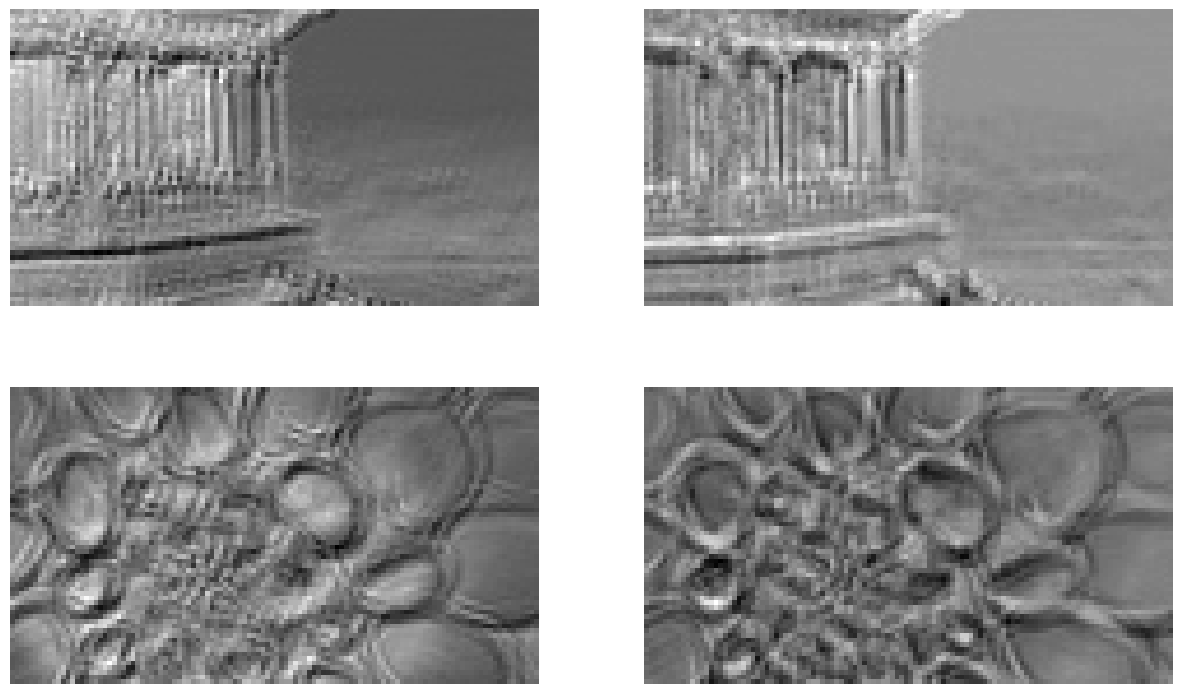

In [7]:
plt.figure(figsize=(15, 9))
for imageId in (0, 1):
    for fmapId in (0,1):
        plt.subplot(2, 2, imageId * 2 + fmapId + 1)
        plt.imshow(featureMaps[imageId, : , : , fmapId], cmap = "gray")
        plt.axis("off")
plt.show()

now with zero padding

In [8]:
convLayerPadding = tf.keras.layers.Conv2D(filters = 32, kernel_size=7, padding="same")
paddedFMaps = convLayerPadding(images)
paddedFMaps.shape

TensorShape([2, 70, 120, 32])

its the same as images shape .
Now with strides

In [9]:
convLayerStridesPadding = tf.keras.layers.Conv2D(
    filters = 32, 
    kernel_size=7, 
    padding="same",
    strides = 2)
paddedStridesFMaps = convLayerStridesPadding(images)
paddedStridesFMaps.shape

TensorShape([2, 35, 60, 32])

In [10]:
weights, biases =convLayer.get_weights()
weights.shape

(7, 7, 3, 32)

manually creating the filters using tf.nn.conv2d

In [11]:
tf.random.set_seed(42)
filters = tf.random.normal([7, 7, 3, 2])
biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images,filters, strides = 1, padding="SAME") + biases
# numimages. width, height, numfilters
fmaps.shape 

TensorShape([2, 70, 120, 2])

manually creating horizontal and verticle filters

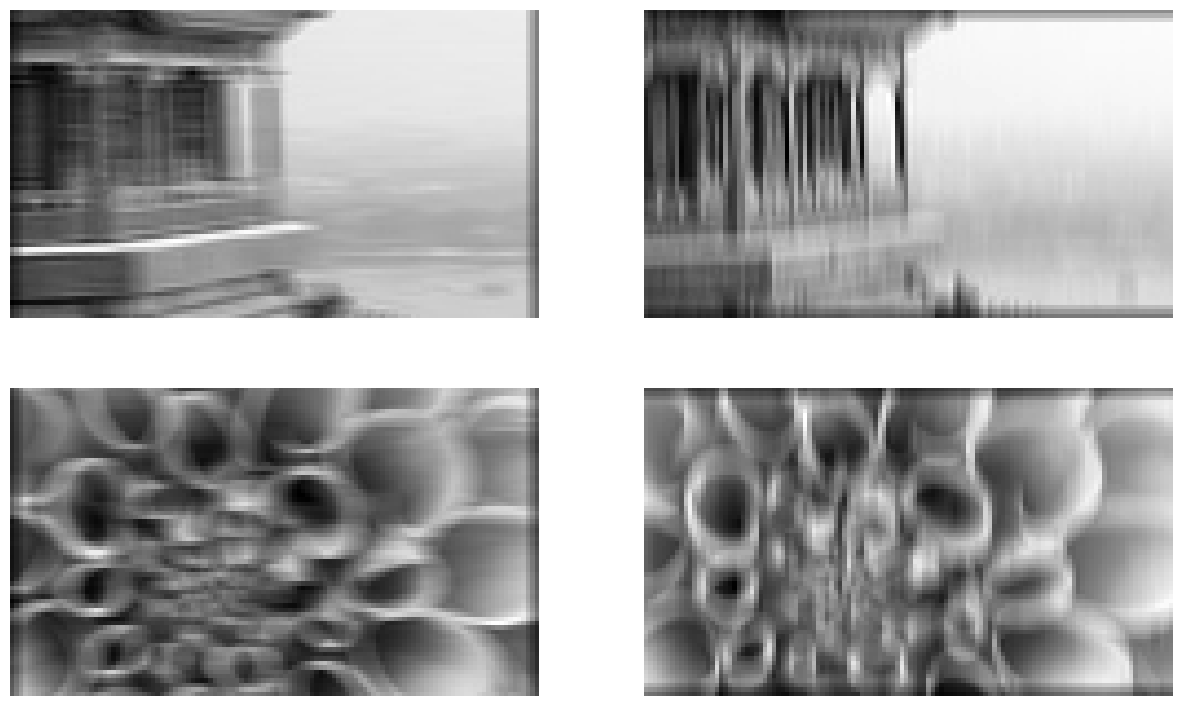

In [12]:
import numpy as np
filters = np.zeros([7, 7, 3, 2])
# horizontal filter
filters[3, :, :, 0] = 1
# verticle filter 
filters[:,3 , :, 1] = 1 
fmaps = tf.nn.conv2d(images, filters, strides = 1, padding = "SAME")

plt.figure(figsize=(15, 9))
for imageId in (0, 1):
    for fmapId in (0, 1):
        plt.subplot(2,2, imageId * 2 + fmapId + 1)
        plt.imshow(fmaps[imageId, :, :,fmapId], cmap= "gray")
        plt.axis("off")
plt.show()

max pooling example

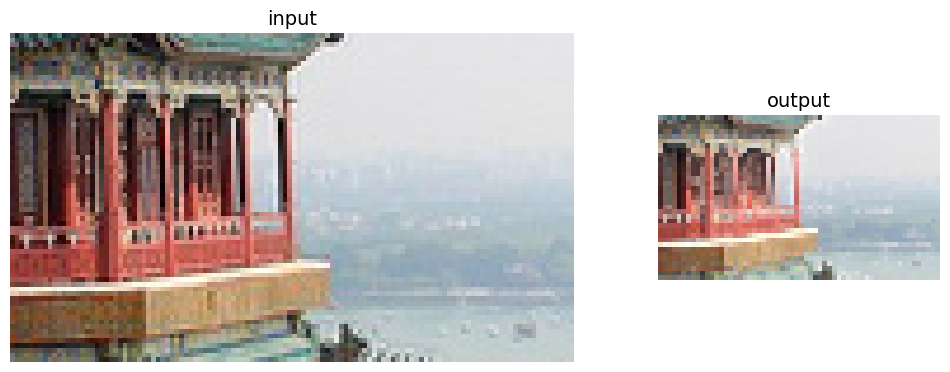

In [13]:
maxPoolLayer = tf.keras.layers.MaxPool2D(pool_size=2)
maxPoolOuput = maxPoolLayer(images)

import matplotlib as mpl 

fig = plt.figure(figsize=(12, 9))
gs = mpl.gridspec.GridSpec(nrows = 1, ncols = 2, width_ratios = [2, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("input")
ax1.axis("off")
ax1.imshow(images[0])

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("output")
ax2.axis("off")
ax2.imshow(maxPoolOuput[0])

plt.show()

In [14]:
# extra code – shows how to use the max_pool() op; only works on the CPU
np.random.seed(42)
fmaps = np.random.rand(2, 70, 120, 60) # last dimension is for number of features
with tf.device("/cpu:0"):
    output = tf.nn.max_pool(fmaps, ksize=(1, 1, 1, 60), strides=(1, 1, 1, 60),
                            padding="VALID")
output.shape

TensorShape([2, 70, 120, 1])

In [15]:
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
    
    def call(self, inputs):
        shape = tf.shape(inputs)  # shape[-1] is the number of channels
        # print(f"shape : {shape}")
        groups = shape[-1] // self.pool_size  # number of channel groups
        # print(f"groups : {groups}")
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        # print(f"new_shape : {new_shape}")
        test = tf.reshape(inputs, new_shape)
        # print(f"test.shape : {test.shape}")
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)
    
result = DepthPool(pool_size= 3)(images)
result.shape

TensorShape([2, 70, 120, 1])

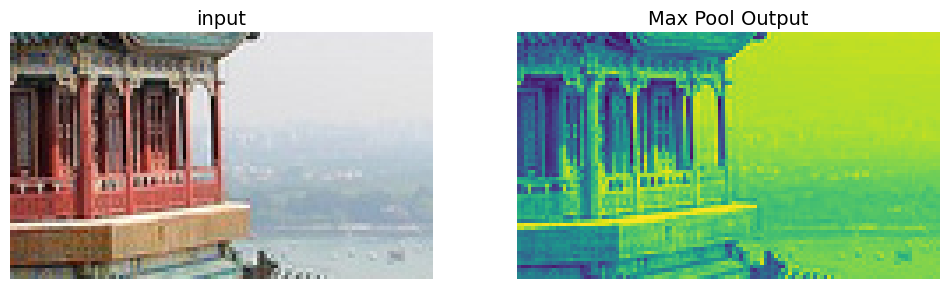

In [16]:
maxPoolImages = DepthPool(pool_size= 3)(images)
# plotting the dept wise max pool image 
plt.figure(figsize=(12, 9))
plt.subplot(1, 2, 1)
plt.title("input")
plt.axis("off")
plt.imshow(images[0])

plt.subplot(1, 2, 2)
plt.title("Max Pool Output")
plt.axis("off")
plt.imshow(maxPoolImages[0, ..., 0])

plt.show()

testing mnist fashion data using CNN

In [17]:
mnist = tf.keras.datasets.fashion_mnist.load_data()
(xTrainFull, yTrainFull), (xTest, yTest) = mnist
xTrainFull.shape

(60000, 28, 28)

In [18]:
xTrainFull = np.expand_dims(xTrainFull, axis=-1).astype(np.float32) / 255
xTest = np.expand_dims(xTest.astype(np.float32), axis=-1) / 255

xTrainFull.shape

(60000, 28, 28, 1)

In [19]:
xTest.shape

(10000, 28, 28, 1)

In [20]:
xTrain, xVal = xTrainFull[:-5000] , xTrainFull[-5000 : ]
yTrain , yVal = yTrainFull[:-5000] , yTrainFull[-5000 : ]

In [21]:
from functools import partial

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size = 3, padding = "same", kernel_initializer = "he_normal", activation = "relu")

model = tf.keras.Sequential([
    DefaultConv2D(filters = 64, input_shape = [28, 28, 1], kernel_size = 7),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters = 128),
    DefaultConv2D(filters = 128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters = 256),
    DefaultConv2D(filters = 256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 128, activation= "relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units = 64, activation= "relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units = 10, activation="softmax")
])

model.compile(loss = "sparse_categorical_crossentropy", optimizer = "nadam", metrics = ["accuracy"])
history = model.fit(xTrain, yTrain, validation_data = (xVal, yVal), epochs = 10)
score = model.evaluate(xTest, yTest)
print(f"score : {score}")

/home/furrukh/furrukhUbuntu/sk-learn/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


I0000 00:00:1756297642.667422    1176 service.cc:152] XLA service 0x7fbd08005620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756297642.667469    1176 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-08-27 17:27:22.919989: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


   2/1719 ━━━━━━━━━━━━━━━━━━━━ 1:33 54ms/step - accuracy: 0.1875 - loss: 3.5385  

I0000 00:00:1756297651.529952    1176 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6292 - loss: 1.0634

2025-08-27 17:28:13.881440: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_104', 12 bytes spill stores, 12 bytes spill loads

2025-08-27 17:28:13.918538: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_104', 4 bytes spill stores, 4 bytes spill loads



1719/1719 ━━━━━━━━━━━━━━━━━━━━ 60s 27ms/step - accuracy: 0.6292 - loss: 1.0632 - val_accuracy: 0.8576 - val_loss: 0.3919
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.8506 - loss: 0.4430 - val_accuracy: 0.8730 - val_loss: 0.3856
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.8764 - loss: 0.3704 - val_accuracy: 0.8970 - val_loss: 0.2791
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.8938 - loss: 0.3207 - val_accuracy: 0.9020 - val_loss: 0.2779
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9041 - loss: 0.2927 - val_accuracy: 0.9080 - val_loss: 0.2479
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.9133 - loss: 0.2597 - val_accuracy: 0.9022 - val_loss: 0.2724
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9154 - loss: 0.2488 - val_accuracy: 0.9038 - val_loss: 0.2818
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.9211 - loss: 0.23

In [22]:
xNew = xTest[:10]
preditions = model.predict(xNew)

predClasses = np.argmax(preditions, axis =1)
predClasses

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

implementing ResNet34 

In [24]:
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size = 3,  padding = "same",use_bias = False, kernel_initializer = "he_normal")

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides = 1, activation = "relu", **kwarg):
        super().__init__(**kwarg)
        self.activation = tf.keras.activations.get(activation) 

        self.mainLayer = [
            DefaultConv2D(filters , strides = strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]

        self.skipLayer = []
        if strides > 1:
            self.skipLayer = [
                DefaultConv2D(filters, kernel_size = 1, strides = strides),
                tf.keras.layers.BatchNormalization()
            ]
    def call(self, inputs):
        z = inputs 
        for layer in self.mainLayer:
            z = layer(z)
        zSkip = inputs 
        for layer in self.skipLayer:
            zSkip = layer(zSkip)

        return self.activation(z + zSkip)

model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size= 7 , strides = 2, input_shape = [224, 224, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size= 3, strides = 2, padding = "same")
])
prevFilter = 64
for filter in [64]* 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if prevFilter == filter else 2
    model.add(ResidualUnit(filter, strides= strides))
    prevFilter = filter 

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units = 10, activation="softmax"))


/home/furrukh/furrukhUbuntu/sk-learn/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


creating the model using keras built in models

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 89s 1us/step


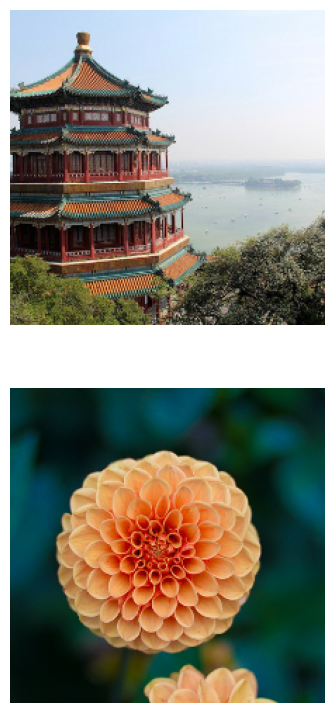

In [25]:
model = tf.keras.applications.ResNet50(weights = "imagenet")

images = tf.constant(load_sample_images()["images"])
resizedImages = tf.keras.layers.Resizing(width= 224, height= 224, crop_to_aspect_ratio=True)(images)

plt.figure(figsize = (10, 9))
for id in (0, 1):
    plt.subplot(2, 1 , id + 1)
    plt.imshow(resizedImages[id]/255)
    plt.axis("off")

plt.show()

In [26]:
inputs = tf.keras.applications.resnet50.preprocess_input(resizedImages)
yProb = model.predict(inputs)
yProb.shape

2025-08-27 18:50:10.588023: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1678', 8 bytes spill stores, 8 bytes spill loads

2025-08-27 18:50:10.743045: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1678', 12 bytes spill stores, 12 bytes spill loads

2025-08-27 18:50:10.743104: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1678', 120 bytes spill stores, 120 bytes spill loads

2025-08-27 18:50:11.022168: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1678', 3876 bytes spill stores, 3868 bytes spill loads

2025-08-27 18:50:11.161860: I extern

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


(2, 1000)

In [28]:
top_k = tf.keras.applications.resnet50.decode_predictions(yProb, top = 5)
for imageId in (0,1):
    print(f"image # {imageId}")
    for classId, name , prob in top_k[imageId]:
        print(f"classid : {classId}, name : {name}, probability : {prob:.2%}")

image # 0
classid : n03877845, name : palace, probability : 54.82%
classid : n03781244, name : monastery, probability : 24.42%
classid : n02825657, name : bell_cote, probability : 18.71%
classid : n02980441, name : castle, probability : 0.78%
classid : n04346328, name : stupa, probability : 0.34%
image # 1
classid : n04522168, name : vase, probability : 32.15%
classid : n11939491, name : daisy, probability : 17.83%
classid : n03530642, name : honeycomb, probability : 12.03%
classid : n13040303, name : stinkhorn, probability : 4.49%
classid : n07930864, name : cup, probability : 4.19%
